In [ ]:
Pkg.update()
Pkg.add("Jacobi")
Pkg.add("FastGaussQuadrature")
Pkg.add("PyPlot")

In [1]:
using FastGaussQuadrature
using Jacobi

f_0 = 1
H = 1
nodePoints=100

function b_n(n::Int64)
    numerator = -n*(n+1)
    denominator = (n+2)*(n+3)
    return numerator/denominator
end

function M_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1, j+1] = 2/(2*i+1) + (b_n(i)*b_n(i))*(2/(2*i+5))
            elseif i==j+2
                fullMatrix[i+1, j+1] = b_n(j)*(2/(2*j+5))
            elseif i==j-2
                fullMatrix[i+1, j+1] = b_n(i)*(2/(2*j+5))
            end
        end
    end
    return fullMatrix/2
end

function B_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1,j+1]=2/(2*i+1)
            elseif i==j-2
                fullMatrix[i+1,j+1]=b_n(i)*2/(2*i+5)
            end
        end
    end
    return fullMatrix/2
end

function L_ij(size::Int64, N::Function)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dp_i = 2.*(djacobi(values[k+1],i,0,0)+b_n(i)*djacobi(values[k+1],i+2,0,0))
                dp_j = 2.*(djacobi(values[k+1],j,0,0)+b_n(j)*djacobi(values[k+1],j+2,0,0))
                newPiece = weights[k+1]*(f_0*f_0/(H*H*N((values[k+1]+1.)/2.)*N((values[k+1]+1.)/2.)))*dp_i*dp_j
                sumTotal = sumTotal + newPiece
            end
            fullArray[i+1,j+1] = .5*sumTotal
        end
    end
    return fullArray
end

function N_constant(value::Float64)
    return 1.
end

function galerkin_p_psi_print(size::Int64, coefficients, value)
    sumTotal = 0
    for i=0:size-1
        p = jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0)
        sumTotal = sumTotal + coefficients[i+1]*(jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0))
    end
    return sumTotal
end
;


Use "local i; local k; local iter=0" instead.

Use "abstract type QUADRATURE_TYPE end" instead.


# Linear Stability - Eady Problem

In [2]:
function dq_galerkin_coefficients(size::Int64, dq_bar::Function)
    fullArray = zeros(size)
    values, weights = gausslegendre(nodePoints)
    for i =0:size-1
        sumTotal = 0
        for k=0:nodePoints-1
            p_n = jacobi(values[k+1], i,0,0)
            sumTotal = sumTotal + weights[k+1]*p_n*dq_bar((values[k+1]+1.)/2.)
        end
        fullArray[i+1] = .5*sumTotal
    end
    return fullArray
end

function dq_galerkin(size::Int64, coefficients, value::Float64)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*jacobi(2.*value-1.,i,0,0)
    end
    return sumTotal
end

function p_psi_function(size::Int64, value::Float64)
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)+b_n(i)*jacobi(2.*value-1.,i+2,0,0)
    end
    return fullArray
end

function p_q_function(size::Int64, value::Float64) # We shouldn't need this function
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)
    end
    return fullArray
end

function dy_vartheta_bar(N::Function, du_bar::Function, value::Float64)
    return -(f_0*f_0/(H*H*N(value)*N(value)))*du_bar(value)
end

function dy_psi(u_bar::Function, value::Float64)
    return -u_bar(value)
end

function dy_psi_galerkin(size::Int64, u_bar_coefficients, value::Float64)
    return -u_galerkin(size, u_bar_coefficients, value)
end

function u_galerkin_coefficients(size::Int64, dq_coefficients, first_u_coefficient, du_bar::Function, N::Function, LMatrix, BMatrix)
    r_piece1 = BMatrix*dq_coefficients
    r_piece2 = dy_vartheta_bar(N,du_bar,1.0)*p_psi_function(size,1.0)
    r_piece3 = dy_vartheta_bar(N,du_bar,0.0)*p_psi_function(size,0.0)
    rhs = r_piece1-r_piece2+r_piece3
    lhs = LMatrix[2:size,2:size]
    rhs = rhs[2:size]
    coefficients = lhs \ rhs
    return prepend!(coefficients,[first_u_coefficient])
end

function u_galerkin(size::Int64, coefficients, value::Float64)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*(jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0))
    end
    return sumTotal
end

u_galerkin (generic function with 1 method)

In [3]:
function U_ij(size::Int64, u_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                p_psi = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_q = jacobi(values[k+1],j,0,0)
                u_galerk = u_galerkin(size, u_galerkin_coefficients, (values[k+1]+1.)/2.)
                sumTotal = sumTotal + weights[k+1]*p_psi*p_q*u_galerk
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end

function Q_ij(size::Int64, dq_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dq_galerk = dq_galerkin(size, dq_galerkin_coefficients, (values[k+1]+1.)/2.)
                p_psi_i = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_psi_j = jacobi(values[k+1],j,0,0)+b_n(j)*jacobi(values[k+1],j+2,0,0)
                sumTotal = sumTotal + weights[k+1]*dq_galerk*p_psi_i*p_psi_j
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end
;

In [ ]:
function z_linear(value::Float64)
    return value
end

function dz(value::Float64)
    return 1
end 

function dq(value::Float64)
    return 0
end
first_coefficient = 0.5
matrixSize = 9
B = B_ij(matrixSize)
L = L_ij(matrixSize, N_constant)
M = M_ij(matrixSize)

dqc = dq_galerkin_coefficients(matrixSize, dq)
ugc = u_galerkin_coefficients(matrixSize, dqc, first_coefficient, dz, N_constant, L, B)

u_galerkin(matrixSize, ugc, 1.)
#U_ij(matixSize, ugc)

#dq_galerkin(matrixSize, dqc, .3)
#Q_ij(matrixSize, dqc)

In [ ]:
function psi(size, kx, ky, M_matrix, L_matrix, value)
    first_piece = (kx^2+ky^2)*M_matrix+L_matrix
    second_piece = p_psi_function(size, value)
    return first_piece \ second_piece
end

function growthRateEigenValues(sizeOfMatrix, beta_value, ky, kxValues, steps)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, N_constant)
    M = M_ij(sizeOfMatrix)
    dq_coefficients = dq_galerkin_coefficients(sizeOfMatrix, dq)
    u_coefficients = u_galerkin_coefficients(sizeOfMatrix, dq_coefficients, first_coefficient, dz, N_constant, L, B)
    U = U_ij(sizeOfMatrix, u_coefficients)
    Q = Q_ij(sizeOfMatrix, dq_coefficients)
    println("Matrices Computed")
    #Should have stable eigenvalues
    (values, vectors) = eig(U, B)
    println(values)
    
    growthRates = zeros(steps)
    waveSpeeds = zeros(steps)
    minWaveSpeeds = zeros(steps)
    eigenvectors = []
    for i=1:steps
        #println()
        kx = kxValues[i]
        #println("k_x value $kx")
        dvt_plus = dy_vartheta_bar(N_constant, dz, 1.)
        dvt_minus = dy_vartheta_bar(N_constant, dz, 0.)
        ul = u_galerkin(sizeOfMatrix, u_coefficients, 1.)+dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        ur = -dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        ll = dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        lr = u_galerkin(sizeOfMatrix, u_coefficients, 0.)-dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        lhs = [[ul ur]; [ll lr]]
        #println(lhs)
        eigenObject = eigfact(lhs)
        max_im = maximum(imag(eigenObject[:values]))
        #println(eigenObject[:vectors])
        append!(eigenvectors, [eigenObject[:vectors]])
        waveSpeeds[i] = maximum(real(eigenObject[:values]))
        minWaveSpeeds[i] = minimum(real(eigenObject[:values]))
        growthRates[i] = max_im*kx
    end
    return growthRates, eigenvectors, waveSpeeds, minWaveSpeeds
end

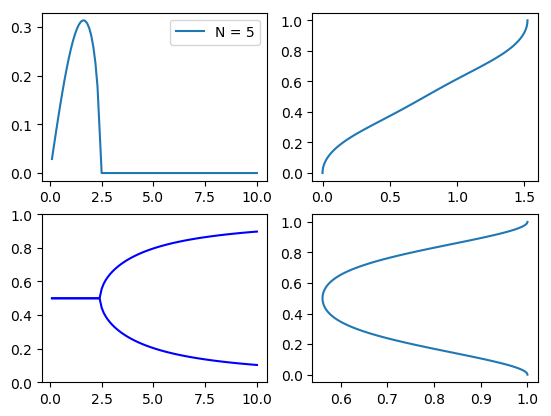

Matrices Computed
[0.938674, 0.745746, 0.0613256, 0.5, 0.254254]


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6ea4ed1f98>

In [9]:
using PyPlot
ioff()

nodePoints = 100 # nodePoints already defined above
matrixSize = 5

B = B_ij(matrixSize)
L = L_ij(matrixSize, N_constant)
M = M_ij(matrixSize)

kxStart = 0.1
kxFinish = 10.
steps = 100
beta = 0
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates, vectors, w_speeds, w_minSpeeds = growthRateEigenValues(matrixSize, beta, ky, kxs, steps)

highVector = vectors[16]
psi_coeffs = highVector[1]*psi(matrixSize, 1.6, ky, M, L, 1.)-highVector[2]*psi(matrixSize,1.6,ky, M,L,0.)

heights = linspace(0,1,100)
psi_angles = zeros(length(heights))
psi_amps = zeros(length(heights))
for i=1:length(heights)
    psi_val = galerkin_p_psi_print(matrixSize, psi_coeffs, heights[i])
    psi_angles[i] = angle(psi_val)
    psi_amps[i] = abs(psi_val)
end

#print(kxs[25])
fig, axes = subplots(2,2)
ax = axes[1,1]
ax[:plot](kxs, growthRates, label="N = $matrixSize")
ax[:legend](loc="upper right")
ax = axes[2,1]
ax[:plot](kxs, w_speeds, "b-")
ax[:plot](kxs, w_minSpeeds, "b-")
ax[:set_ylim]([0,1])
ax = axes[1,2]
ax[:plot](psi_angles - psi_angles[1], heights)

ax = axes[2,2]
ax[:plot](psi_amps/maximum(psi_amps), heights)

# First Baroclinic Mode Comparison

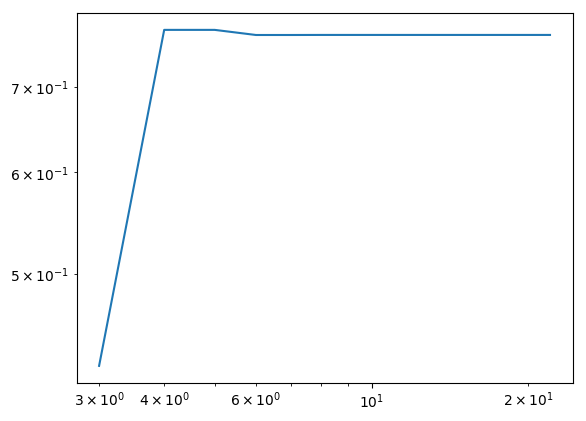

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002FE28518>

In [18]:
using PyPlot

function isNonZero(value)
    return (value != 0)
end

function firstBaroclinic(value)
    return cos.(pi*value)
end

function computeFirstBaroclinicError(matrixSize, trueFirstFuction, stepsZeroToOne)
    #Compute Matricies
    M = M_ij(matrixSize)
    #spy(Hermitian(M))
    L = L_ij(matrixSize, N_constant)
    G = chol(Hermitian(M))

    #Compute eigenvalues and eigenvectors
    LGL = (G\L)/(G')
    eigenObject = eigfact(LGL)
    e_vectors = eigenObject[:vectors]
    e_values = eigenObject[:values]
    minimumNonZero = minimum(filter!(isNonZero,e_values))
    index = findfirst(e_values, minimumNonZero)
    neededEVector = e_vectors[:,index]
    #println(neededEVector)
    normalizationFactor = 1/galerkin_p_psi_print(matrixSize, neededEVector, 0.)
    
    #Calculate Error
    z = linspace(0,1,stepsZeroToOne)
    real = trueFirstFuction(z)
    estimate = galerkin_p_psi_print(matrixSize, neededEVector*normalizationFactor, z)
    #println(real)
    #println(estimate)
    sumError = 0.
    for i=1:length(z)
        sumError += abs2(real[i]-estimate[i])
    end
    totalError = sqrt(sumError)
    return totalError
end

#computeFirstBaroclinicError(15, firstBaroclinic, 10)

errors = zeros(20)
for i =3:22
    #println("N = $i")
    errors[i-2] = computeFirstBaroclinicError(i, firstBaroclinic, 1000)
    #println()
end
loglog(3:22, errors)